# Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

**Implementacja algorytmu drzewa decyzyjnego**

In [1]:
import math
import numpy as np
from collections import Counter

def entropy(class_count, num_samples):
    entropy = -sum([((i/num_samples)*math.log2(i/num_samples)) for i in class_count])
    return entropy

class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return self.group_classes.size

    def group_entropy(self):
        _, class_counts = np.unique(self.group_classes, return_counts=True)
        return entropy(class_counts, len(self))


class Node:
    def __init__(self, split_feature = None, split_value = None, depth=None, child_a=None, child_b=None, value=None):
        self.split_feature = split_feature
        self.split_value = split_value
        self.depth = depth
        self.child_a = child_a
        self.child_b = child_b
        self.value = value

    def predict(self, data):
        if self.value is not None:
            return self.value
        if data[self.split_feature] < self.split_value:
            return self.child_a.predict(data)
        else:
            return self.child_b.predict(data)


class DecisionTreeClassifier:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        total_len = len(group_a) + len(group_b)
        split_entropy = group_a.entropy*(len(group_a)/total_len) + group_b.entropy*(len(group_b)/total_len)
        return split_entropy

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        return parent_group.entropy - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values, classes):
        best_split_value = None
        best_info_gain = float('-inf')
        for split_value in feature_values:            
            group_a = Group(classes[feature_values < split_value])
            group_b = Group(classes[feature_values >= split_value])
            info_gain = self.get_information_gain(Group(classes), group_a, group_b)

            if info_gain > best_info_gain:
                best_split_value = split_value
                best_info_gain = info_gain
        
        return best_split_value, best_info_gain

    def get_best_split(self, data, classes):
        best_split_feature = None
        best_split_value = None
        best_info_gain = float('-inf')
        
        for feature_id in range(data.shape[1]):
            feature_values = data[:, feature_id]
            split_value, info_gain = self.get_best_feature_split(feature_values, classes)
            
            if info_gain > best_info_gain:
                best_split_feature = feature_id
                best_split_value = split_value
                best_info_gain = info_gain
        
        return best_split_feature, best_split_value

    def build_tree(self, data, classes, depth=0):
        unique_classes = np.unique(classes)
        
        if len(unique_classes) == 1:
            return Node(value=unique_classes[0])
        
        if depth == self.max_depth:
            return Node(value=Counter(classes).most_common(1)[0][0])
        
        split_feature, split_value = self.get_best_split(data, classes)
        if split_feature is None:
            return Node(value=Counter(classes).most_common(1)[0][0])
        
        data_a = data[data[:, split_feature] < split_value]
        classes_a = classes[data[:, split_feature] < split_value]
        child_a = self.build_tree(data_a, classes_a, depth+1)
    
        data_b = data[data[:, split_feature] >= split_value]
        classes_b = classes[data[:, split_feature] >= split_value]
        child_b = self.build_tree(data_b, classes_b, depth+1)
        
        return Node(split_feature, split_value, depth, child_a, child_b)

    def fit(self, data, classes):
        self.tree = self.build_tree(data, classes)

    def predict(self, data):
        return self.tree.predict(data)

**Test na podanym zbiorze**

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [3]:
dc = DecisionTreeClassifier(3)
dc.fit(x_train, y_train)
correct_predictions = 0
for sample, correct in zip(x_test, y_test):
    prediction = dc.predict(sample)
    print(f'Prediction: {prediction}, Correct: {correct}')
    if prediction == correct:
        correct_predictions += 1
accuracy = correct_predictions / len(y_test)
print (f'Accurancy: {accuracy:.3f}')
    


Prediction: 2, Correct: 1
Prediction: 2, Correct: 2
Prediction: 2, Correct: 2
Prediction: 1, Correct: 1
Prediction: 0, Correct: 0
Prediction: 2, Correct: 2
Prediction: 1, Correct: 1
Prediction: 0, Correct: 0
Prediction: 0, Correct: 0
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 0, Correct: 0
Prediction: 1, Correct: 1
Prediction: 2, Correct: 2
Prediction: 2, Correct: 2
Accurancy: 0.933


**Eksperymenty dla różnych głębokości drzew i podziałów zbioru treningowego i testowego**

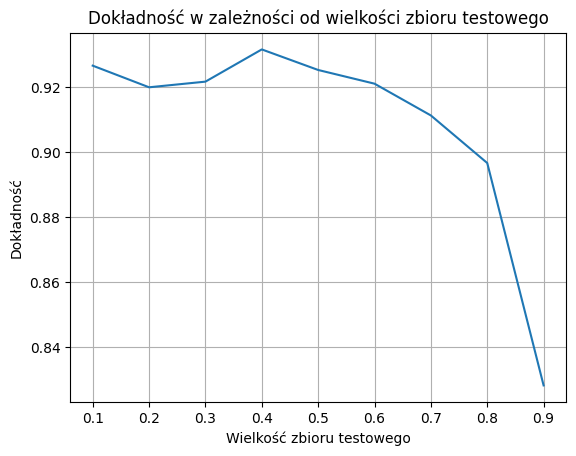

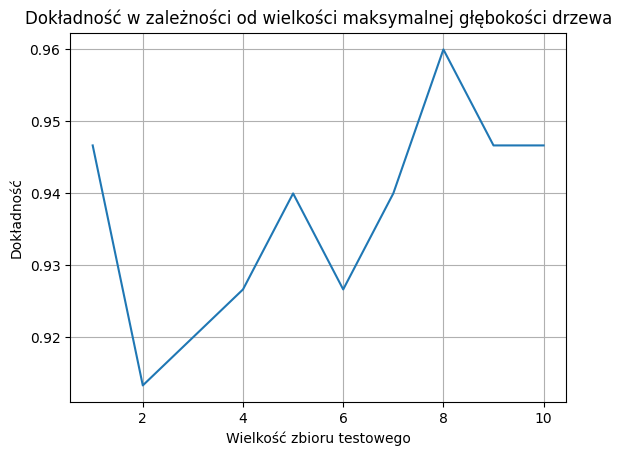

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

def test(test_sizes, depths):
    accuracies = []
    for test_size in test_sizes:
        accuracies_in_10 = []
        for _ in range(10): 
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

            dc = DecisionTreeClassifier(None)
            dc.fit(x_train, y_train)
                
            correct_predictions = 0
            for sample, correct in zip(x_test, y_test):
                prediction = dc.predict(sample)
                if prediction == correct:
                    correct_predictions += 1

            accuracy = correct_predictions / len(y_test)
            accuracies_in_10.append(accuracy)
        accuracies.append(np.mean(accuracies_in_10))
    return accuracies

test_sizes = np.arange(0.1, 1.0, 0.1)
depths = [None]*len(test_sizes)
accuracies = test(test_sizes, depths)

plt.plot(test_sizes, accuracies)
plt.title('Dokładność w zależności od wielkości zbioru testowego')
plt.xlabel('Wielkość zbioru testowego')
plt.ylabel('Dokładność')
plt.grid(True)
plt.show()

depths = range(1,11)
test_sizes = [0.1]*len(depths)
accuracies = test(test_sizes, depths)

plt.plot(depths, accuracies)
plt.title('Dokładność w zależności od wielkości maksymalnej głębokości drzewa')
plt.xlabel('Wielkość zbioru testowego')
plt.ylabel('Dokładność')
plt.grid(True)
plt.show()

